# Random Forest 회귀 분석

## 1. 패키지 참조

In [24]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sb
from matplotlib import pyplot as plt
from pandas import read_excel, DataFrame, get_dummies, to_datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import plot_tree
import dtreeviz

## 2. 데이터 가져오기
- 출처: https://www.ncdc.noaa.gov/cdo-web

> 기후 데이터이다; 예제에서는 미리 준비된 Seattle 데이터를 사용

|변수|설명|
|--|--|
|year|년도|
|month|월|
|day|일|
|week|요일|
|temp2 | 2일 전 최대 온도|
|temp1 | 1일 전 최대 온도|
|average | 과거 평균 최대 온도|
|actual | 최대 온도 (종속변수)|
|friend | your friend's prediction, a random number b/w 20 below the average and 20 above the average|


In [25]:
origin = read_excel('https://data.hossam.kr/G02/noaa_temp.xlsx')
(origin.info())
origin

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB


,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41
...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,Tues,42,42,45.2,47,41,50,47,47
344,2016,12,28,Wed,42,47,45.3,48,41,49,44,58
345,2016,12,29,Thurs,47,48,45.3,48,43,50,45,65
346,2016,12,30,Fri,48,48,45.4,57,44,46,44,42


## 3. 데이터 전처리
### 1) 날짜 인덱스 생성

In [4]:
df = origin.copy()
df['date'] = to_datetime(df[['year', 'month', 'day']])
df.set_index('date', inplace=True)
df.drop(['year', 'month', 'day'], axis=1, inplace=True)
df.head()

,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
date,,,,,,,,,
2016-01-01,Fri,45,45,45.6,45,43,50,44,29
2016-01-02,Sat,44,45,45.7,44,41,50,44,61
2016-01-03,Sun,45,44,45.8,41,43,46,47,56
2016-01-04,Mon,44,41,45.9,40,44,48,46,53
2016-01-05,Tues,41,40,46.0,44,46,46,46,41


### 2) 요일에 대한 더미변수 생성

In [26]:
# 'week' 컬럼을 더미변수화 해서 뒤에 붙여준다, 첫번째 컬럼으로 있던 원래 'week'컬럼은 제거
df2 = get_dummies(df, columns=['week'], drop_first=True)
df2.head()

,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
date,,,,,,,,,,,,,,
2016-01-01,45,45,45.6,45,43,50,44,29,False,False,False,False,False,False
2016-01-02,44,45,45.7,44,41,50,44,61,False,True,False,False,False,False
2016-01-03,45,44,45.8,41,43,46,47,56,False,False,True,False,False,False
2016-01-04,44,41,45.9,40,44,48,46,53,True,False,False,False,False,False
2016-01-05,41,40,46.0,44,46,46,46,41,False,False,False,False,True,False


### 3) 독립/종속 변수 분리

In [27]:
x = df2.drop('actual', axis=1)
y = df2['actual']
x.shape, y.shape

((348, 13), (348,))

### 4) 훈련/검증 데이터 분할

In [28]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.3, random_state = 777
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((243, 13), (105, 13), (243,), (105,))

## 4. Random Forest 회귀 모델 구현
### 1) 학습 모델 적합 (하이퍼파라미터 튜닝)

In [29]:
rfc = RandomForestRegressor(random_state=777, n_jobs=-1)

params = {
    'n_estimators': [20, 50, 100],
    'max_depth': [5, 30, 100]
}

grid = GridSearchCV(rfc, param_grid=params, cv=5, n_jobs=-1)
grid.fit(x_train, y_train)

print('최적의 하이퍼파라미터: ', grid.best_params_)
print('최대 훈련 R^2:', grid.best_score_)

y_pred = grid.best_estimator_.predict(x_test)
print('최대 검증 R^2:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred)) # 평균제곱오차

최적의 하이퍼파라미터:  {'max_depth': 5, 'n_estimators': 100}
최대 훈련 R^2: 0.802180283347942
최대 검증 R^2: 0.8279771677974307
MSE: 23.636015159522906


### 2) 각 변수 별 중요도 (importance) 확인
#### 불순도
- 클래스가 섞이지 않고 `분류가 잘 되었을수록` `불순도가 낮다`
- 반면 클래스가 섞여있고 반반인 경우에는 불순도가 높다
- 의사결정나무 Decision Tree 모델은 이 `불순도가 낮아지는 방향으로 학습`을 한다

#### 지니계수
- 불순도를 측정하는 지표
- 지니계수는 통계적 분산 정도를 정량화해서 표현한 값으로 `0과 1 사이의 값`을 가진다
- 지니계수가 높을수록 잘 분류되지 못한 것

> DecisionTree 모델에서 데이터를 나누는 기준은 지니계수이다. 
> 
> DecisionTree 모델에서 중요도는 지니계수가 얼마나 줄어드는지가 기준이 되는 값이다
>
> Regression 모델의 회귀계수와 달리 항상 양수값을 가지며, 특성의 모든 특성 불순도를 합치면 1이 된다
>
> 회귀분석 모델에서 각 변수의 `설명력을 의미하는 것이 아님`에 유의하자

In [30]:
best_model = grid.best_estimator_
best_model.feature_importances_

array([0.02819389, 0.4537472 , 0.21685066, 0.04556542, 0.21437366,
       0.00803964, 0.01928123, 0.0057472 , 0.00066907, 0.00327036,
       0.00112866, 0.00237041, 0.00076258])

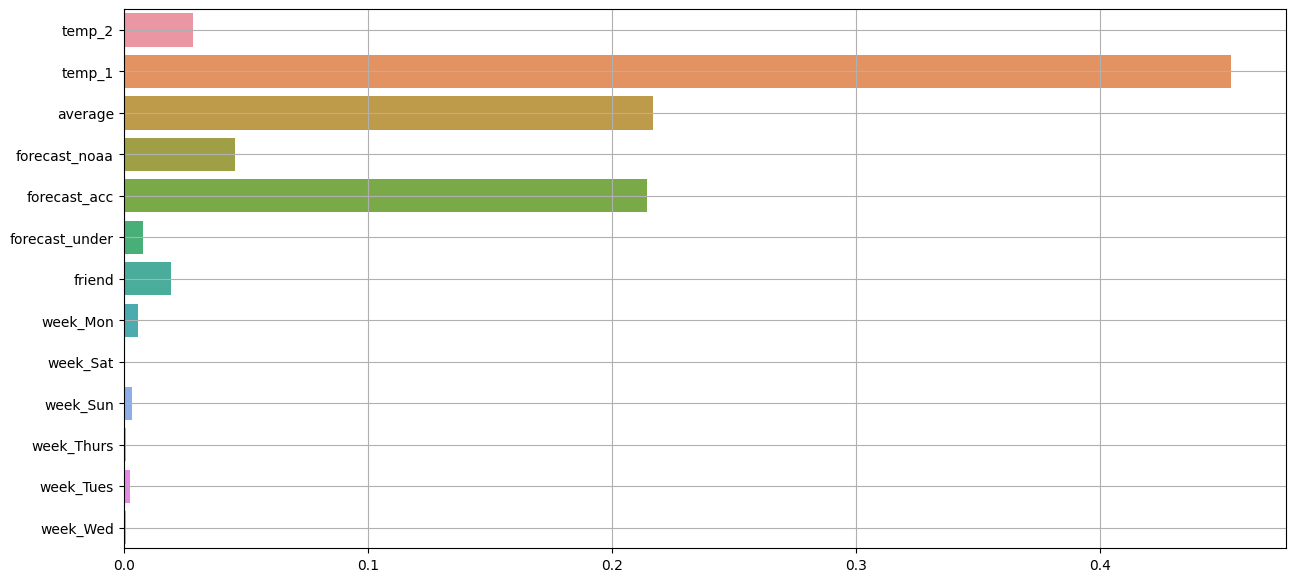

In [31]:
# 시각화
plt.figure(figsize = (15, 7))
sb.barplot(y=x_train.columns, x = best_model.feature_importances_)
plt.grid()
plt.show()
plt.close()

### 3) 임의의 단일 트리 확인
RandomForestRegressor 는 DecisionTree의 배열이다

In [32]:
best_model

RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=777)

In [33]:
len(best_model)

100

In [34]:
best_model[0]

DecisionTreeRegressor(max_depth=5, max_features=1.0, random_state=655685735)

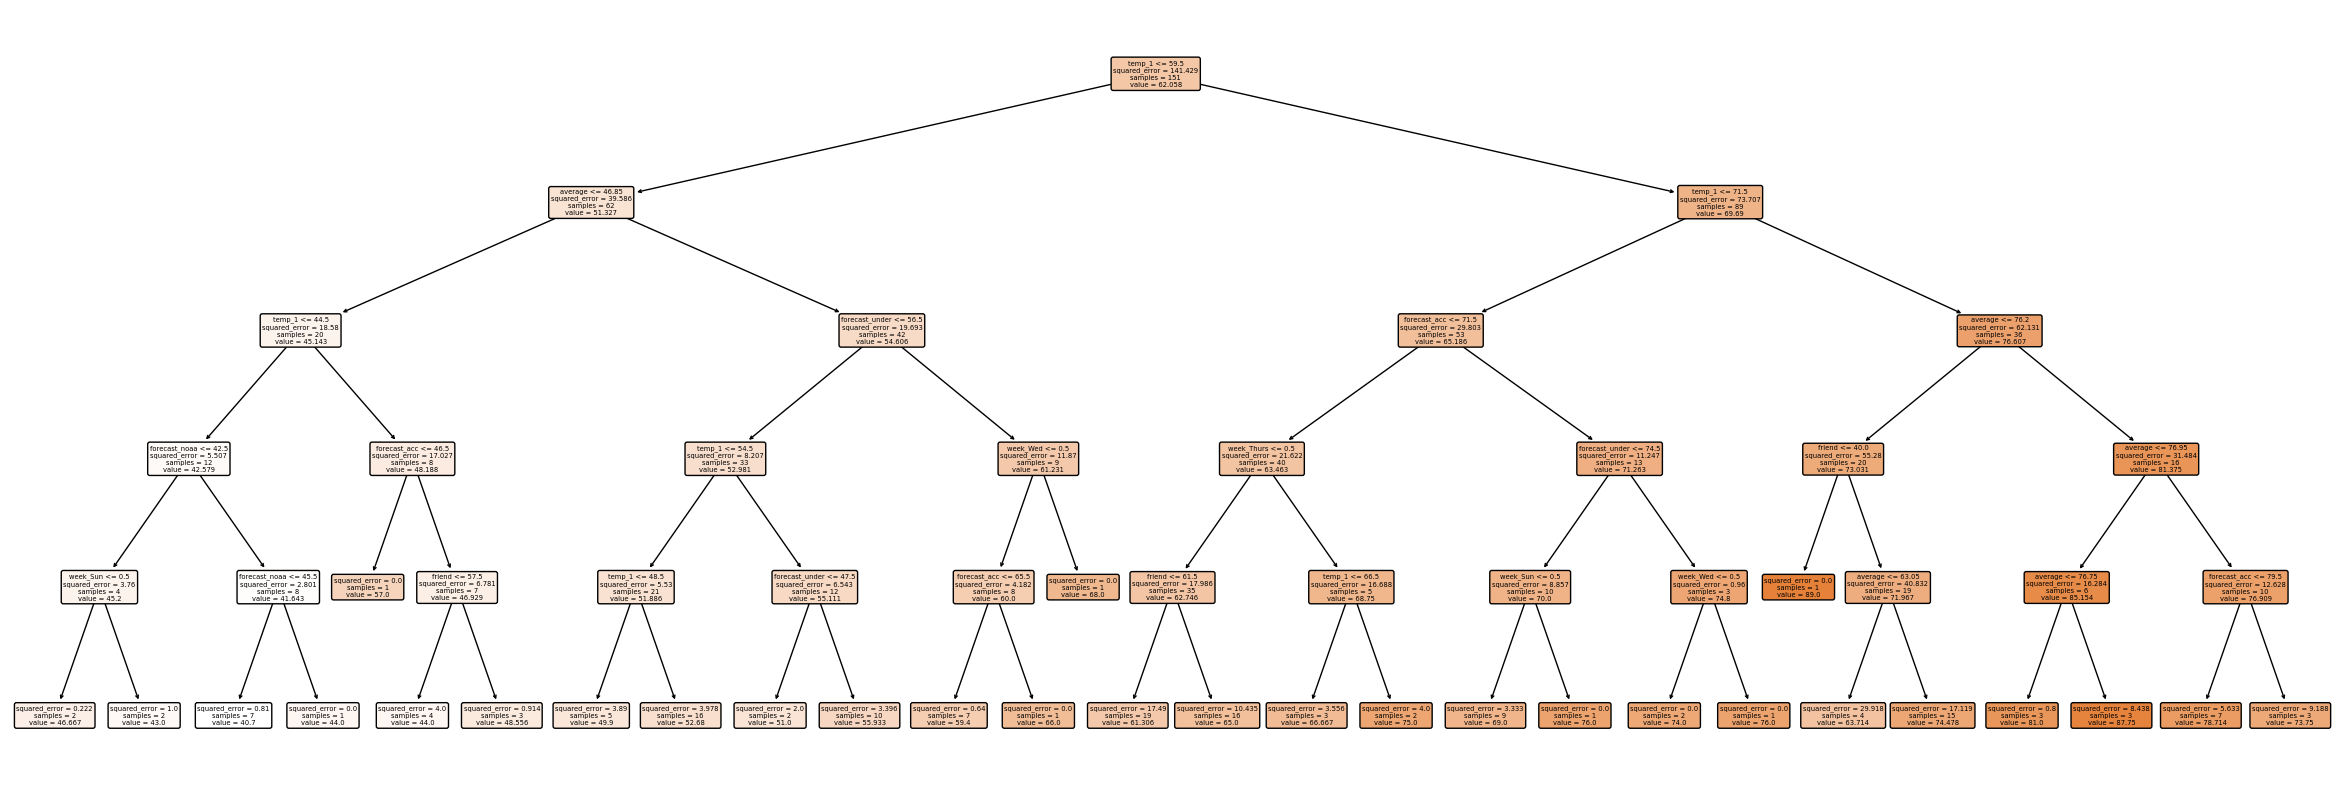

In [35]:
dtree = best_model[0]
plt.figure(figsize=(30, 10))
_ = plot_tree(dtree,
              feature_names = list(x_train.columns),
              rounded=True, # 노드의 모서리를 둥글게
              filled=True)  # 노드의 색상을 다르게
plt.show()
plt.close()

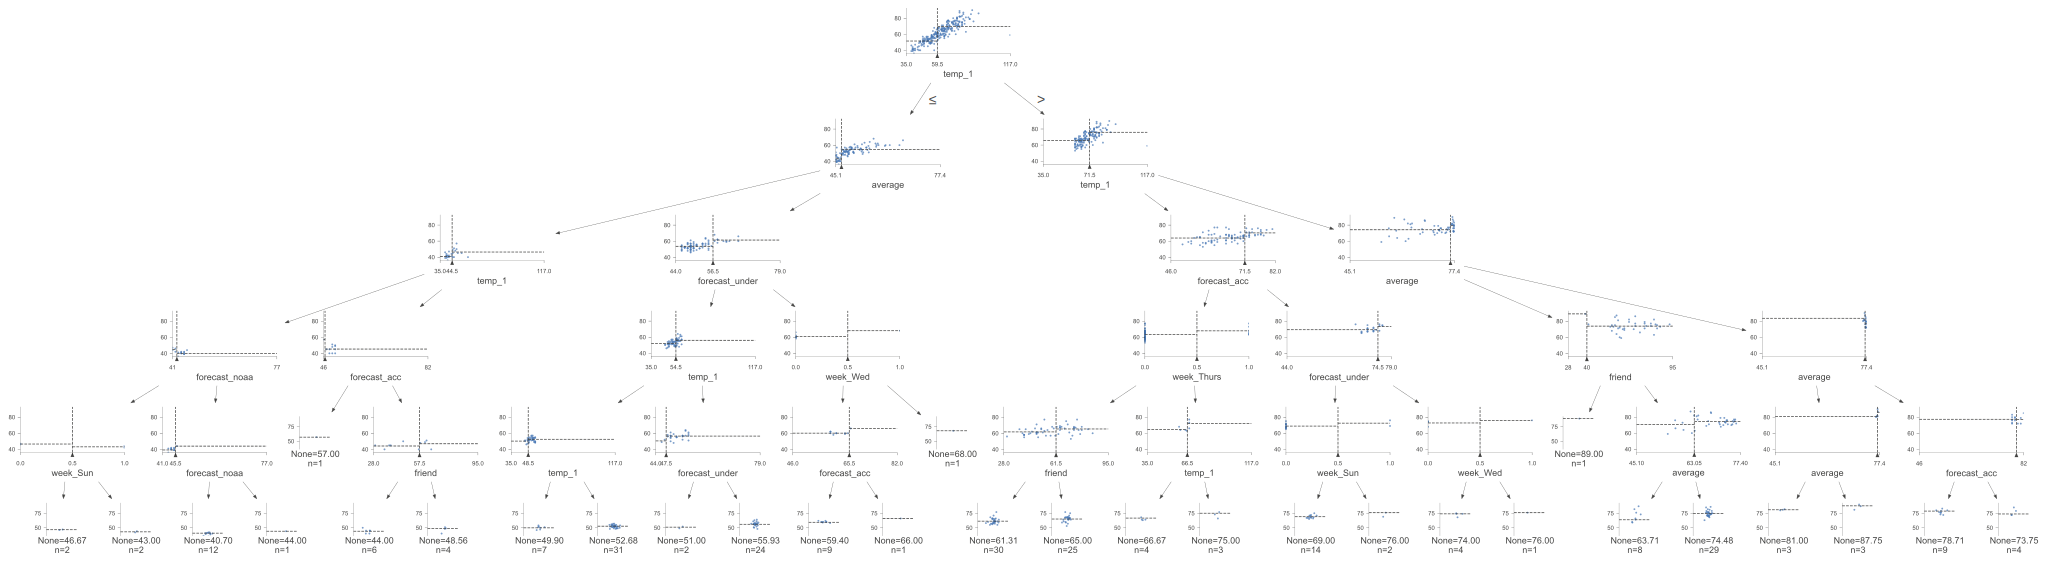

In [40]:
viz = dtreeviz.model(dtree,
                     X_train=x_train,
                     y_train=y_train,
                     feature_names=x_train.columns)
viz.view(scale=2.0)


### 4) 종속 변수에 대한 관측치와 예측값 비교

> 주의: 시계열 분석이 아닌 `회귀분석`이다

In [41]:
pred_df = DataFrame({'y_test': y_test, 'y_pred': y_pred})
# 이대로 출력하면 날짜가 순서대로 되어있지 않는다 (이대로 두면 나중에 시각화 할 때 복잡할 것), 그래서 날짜순으로 정렬 수행
pred_df.sort_index(inplace=True)
pred_df

,y_test,y_pred
date,,
2016-01-02,44,43.897719
2016-01-06,51,41.117181
2016-01-07,45,47.473183
2016-01-08,48,43.070065
2016-01-10,52,47.384239
...,...,...
2016-12-12,43,42.118545
2016-12-13,40,44.854072
2016-12-18,39,38.894986


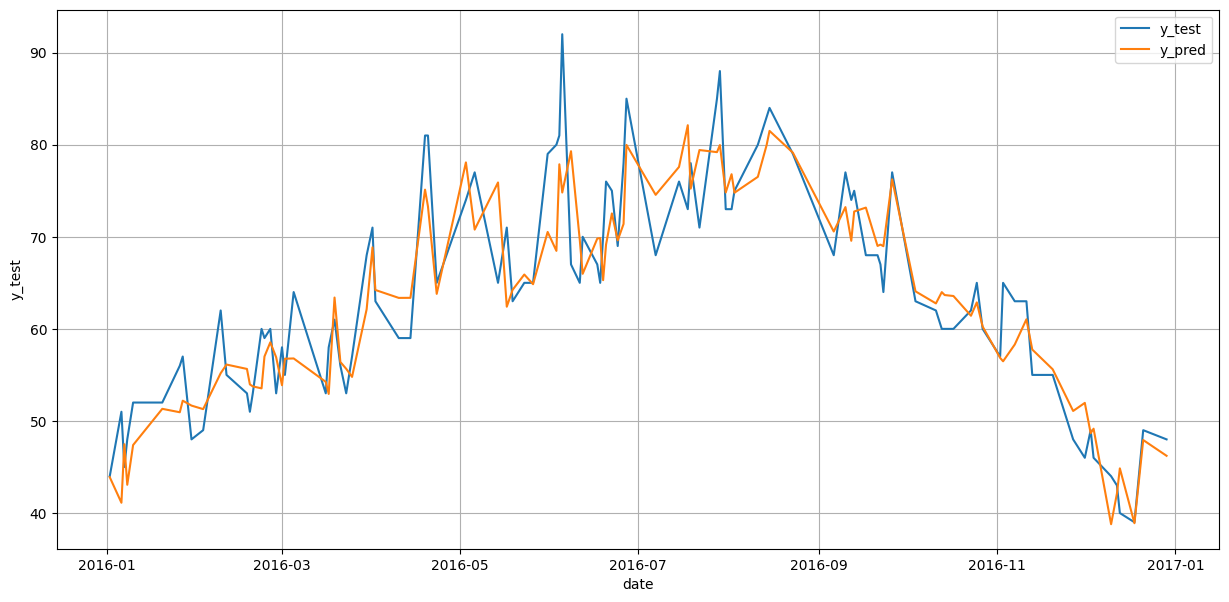

In [42]:
# 시각화
plt.figure(figsize=(15, 7))
sb.lineplot(data=pred_df, x=pred_df.index, y='y_test', label='y_test')
sb.lineplot(data=pred_df, x=pred_df.index, y='y_pred', label='y_pred')
plt.grid()
plt.show()
plt.close()